## Import Data


In [1]:
import pandas as pd
file = pd.read_csv("https://raw.githubusercontent.com/sawsimeon/HDAC-Chembl/master/hdac.txt", sep = "\t")
query = file.query('STANDARD_TYPE == "IC50" and RELATION == "=" and STANDARD_UNITS == "nM"')
query.drop_duplicates(subset = "CANONICAL_SMILES")

IC50 = query['STANDARD_VALUE']
SMILES = query['CANONICAL_SMILES']


In [2]:
query.count(axis=0)

CMPD_CHEMBLID            707
MOLREGNO                 707
PARENT_CMPD_CHEMBLID     707
PARENT_MOLREGNO          707
MOL_PREF_NAME            131
COMPOUND_KEY             707
MOLWEIGHT                700
ALOGP                    697
PSA                      697
NUM_RO5_VIOLATIONS       697
CANONICAL_SMILES         707
ACTIVITY_ID              707
STANDARD_TYPE            707
RELATION                 707
STANDARD_VALUE           707
STANDARD_UNITS           707
PCHEMBL_VALUE            701
ACTIVITY_COMMENT           0
DATA_VALIDITY_COMMENT      6
POTENTIAL_DUPLICATE      707
BAO_ENDPOINT             707
UO_UNITS                 707
QUDT_UNITS               707
ASSAY_ID                 707
ASSAY_CHEMBLID           707
ASSAY_TYPE               707
DESCRIPTION              707
ASSAY_SRC_ID             707
ASSAY_SRC_DESCRIPTION    707
ASSAY_ORGANISM           567
ASSAY_STRAIN               0
ASSAY_TAX_ID             567
CURATED_BY               707
BAO_FORMAT               707
TID           

## Standardized molecules

In [3]:
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import MolFromSmiles,MolToSmiles

remover = SaltRemover()
len(remover.salts)

SMILES_desalt = []

for i in SMILES:
    mol = MolFromSmiles(i) 
    mol_desalt = remover.StripMol(mol)
    mol_SMILES = MolToSmiles(mol_desalt)
    SMILES_desalt.append(mol_SMILES)

## Write SDF file of Standardized molecules

In [6]:
from rdkit.Chem.rdmolfiles import SDWriter
w = SDWriter("HDAC.sdf")
for i in SMILES_desalt:
    mol = MolFromSmiles(i)
    w.write(mol)
    

## Binding the Standardized SMILES with Bioactivity Data

In [11]:
IC50_nm = pd.Series.tolist(IC50)

df = pd.DataFrame({'smiles' : SMILES_desalt,
 'IC50':IC50_nm
  })

## Pharsing the SMILES to calculate Morgan Fingerprint Descriptors

In [12]:
from rdkit.Chem import PandasTools, AllChem
PandasTools.AddMoleculeColumnToFrame(df, smilesCol = 'smiles')
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 1) for m in df['ROMol']]

## Converting RDkit data structure to numerical descriptors

In [13]:
import numpy as np
from rdkit import DataStructs
descriptors = []
for fp in fps:
  arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  descriptors.append(arr)


## Data Transformation (Converting IC50 to pIC50)

In [14]:
from math import log10
import numpy as np
np_ic50 = np.array(IC50)

pIC50 = []
for i in np_ic50:
    molar = i*(10**-9) # Converts nM to M
    pIC50.append(-log10(molar))


y = pIC50
X = descriptors

## Standardizing
Descriptors are standradized before performing PCA analysis. 

In [8]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

## Computing Eigenvectors and Eigenvalues
The PCA approach is to perform the eigendecomposition on the covariance matrix.

In [9]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
sklearn_transf = sklearn_pca.fit_transform(X_std.T)

## Obtain Covariance Matrix

In [10]:
cov_mat = sklearn_pca.get_covariance()

## Perform an eigendecomposition on the covariance matrix

In [11]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_vals = np.around(eig_vals, decimals=1)
eig_vecs = np.around(eig_vecs, decimals = 1)


## Explained Variance Plot 

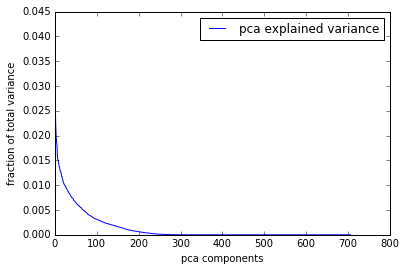

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
pca = sklearnPCA().fit(X_std)
plt.plot(pca.explained_variance_ratio_, label='pca explained variance')
plt.legend(loc='best')
plt.xlabel('pca components')
plt.ylabel('fraction of total variance')

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


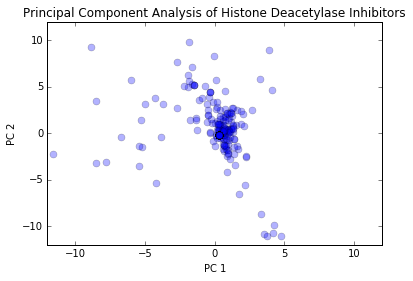

In [13]:
from matplotlib import pyplot as plt
plt.plot(sklearn_transf[0:707,0],sklearn_transf[0:707,1], 'o', markersize=7, color='blue', alpha=0.3)
#plt.plot(sklearn_transf[0:2751,0], sklearn_transf[0:2751,1], '^', markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.xlim([-12,12])
plt.ylim([-12,12])
plt.legend()
plt.title('Principal Component Analysis of Histone Deacetylase Inhibitors')

plt.show()


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def build_models_regression(x, y, model):
   
    
    if model == "training":
        X_train, X_test, y_train, y_test = train_test_split(x, y,
        test_size = 0.2)
        rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt')
        rf.fit(X_train, y_train)
        rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
        r2 = r2_score(y_train, rf.predict(X_train))
        print("The internal set's R-Squared is %.2f  and Root Mean Squared Error is %.2f" % (r2, rmse))
    #rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
    #r2 = r2_score(y_train, rf.predict(X_train))
    #print "The internal set's R-Squared is %.2f  and Root Mean Squared Error is %.2f" % (r2, rmse)
    elif model == "CV":
        X_train, X_test, y_train, y_test = train_test_split(x, y,
        test_size = 0.2)
        rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt')
        rf.fit(X_train, y_train)
        #rmse = np.sqrt(mean_squared_error(y_train, cross_val_predict(rf, X_train, y_train, cv = 10)))
        rmse = np.sqrt(mean_squared_error(y_train, cross_val_predict(rf, X_train, y_train, cv = 10)))
        r2 = r2_score(y_train, cross_val_predict(rf, X_train, y_train, cv = 10))
        print("The 10 fold set's R-Squared is %.2f  and Root Mean Squared Error is %.2f" % (r2, rmse))
    elif model == "testing":
        X_train, X_test, y_train, y_test = train_test_split(x, y,
        test_size = 0.2)
        rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt')
        rf.fit(X_train, y_train)
        rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
        r2 = r2_score(y_test, rf.predict(X_test))
        print("The external set's R-Squared is %.2f  and Root Mean Squared Error is %.2f" % (r2, rmse))
    



## Training performance

In [18]:
build_models_regression(x = descriptors, y = pIC50, model = "training")

The internal set's R-Squared is 0.88  and Root Mean Squared Error is 0.39


## 10-Fold Cross Validation's Performance

In [19]:
build_models_regression(x = descriptors, y = pIC50, model = "CV")

The 10 fold set's R-Squared is 0.53  and Root Mean Squared Error is 0.75


## Testing Performance

In [13]:
build_models_regression(x = descriptors, y = pIC50, model = "testing")

The external set's R-Squared is 0.51  and Root Mean Squared Error is 0.78


## Scrambling for evaluating the predictive models (function)

In [26]:
#Scrambling pIC50
import numpy as np
def scrambling(x, y, model):
   
    
    if model == "R2":
        for i in range(100):
            
            np.random.shuffle(y)
            X_train, X_test, y_train, y_test = train_test_split(x, y,
            test_size = 0.2)
            rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', n_jobs = -1)
            rf.fit(X_train, y_train)
            rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
            r2 = abs(r2_score(y_train, rf.predict(X_train)))
            print("The Scrambled  R-Squared is %.2f" % r2)
    #rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
    #r2 = r2_score(y_train, rf.predict(X_train))
    #print "The internal set's R-Squared is %.2f  and Root Mean Squared Error is %.2f" % (r2, rmse)
    elif model == "Q2":
        for i in range(100):
            np.random.shuffle(y)
            X_train, X_test, y_train, y_test = train_test_split(x, y,
            test_size = 0.2)
            rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', n_jobs = -1)
            rf.fit(X_train, y_train)
            #rmse = np.sqrt(mean_squared_error(y_train, cross_val_predict(rf, X_train, y_train, cv = 10)))
            r2 = cross_val_score(rf, X_train, y_train, cv = 10)
            r2 = abs(r2.mean())
            #r2 = r2_score(y_train, cross_val_predict(rf, X_train, y_train, cv = 10))
            print("The Scrambled Q2 is %.2f" % r2)



### Scrambled R2 for 100 times

In [27]:
scrambling(x = descriptors, y = pIC50, model = "R2")

The Scrambled  R-Squared is 0.62
The Scrambled  R-Squared is 0.60
The Scrambled  R-Squared is 0.66
The Scrambled  R-Squared is 0.64
The Scrambled  R-Squared is 0.64
The Scrambled  R-Squared is 0.59
The Scrambled  R-Squared is 0.61
The Scrambled  R-Squared is 0.59
The Scrambled  R-Squared is 0.58
The Scrambled  R-Squared is 0.64
The Scrambled  R-Squared is 0.65
The Scrambled  R-Squared is 0.63
The Scrambled  R-Squared is 0.63
The Scrambled  R-Squared is 0.62
The Scrambled  R-Squared is 0.64
The Scrambled  R-Squared is 0.68
The Scrambled  R-Squared is 0.62
The Scrambled  R-Squared is 0.66
The Scrambled  R-Squared is 0.61
The Scrambled  R-Squared is 0.61
The Scrambled  R-Squared is 0.60
The Scrambled  R-Squared is 0.64
The Scrambled  R-Squared is 0.59
The Scrambled  R-Squared is 0.62
The Scrambled  R-Squared is 0.65
The Scrambled  R-Squared is 0.63
The Scrambled  R-Squared is 0.65
The Scrambled  R-Squared is 0.62
The Scrambled  R-Squared is 0.62
The Scrambled  R-Squared is 0.61
The Scramb

## Scrambed Q2 for 100 times

In [28]:
scrambling(x = descriptors, y = pIC50, model = "Q2")

The Scrambled Q2 is 0.24
The Scrambled Q2 is 0.14
The Scrambled Q2 is 0.33
The Scrambled Q2 is 0.19
The Scrambled Q2 is 0.33
The Scrambled Q2 is 0.25
The Scrambled Q2 is 0.22
The Scrambled Q2 is 0.22
The Scrambled Q2 is 0.32
The Scrambled Q2 is 0.29
The Scrambled Q2 is 0.21
The Scrambled Q2 is 0.28
The Scrambled Q2 is 0.20
The Scrambled Q2 is 0.28
The Scrambled Q2 is 0.23
The Scrambled Q2 is 0.23
The Scrambled Q2 is 0.30
The Scrambled Q2 is 0.28
The Scrambled Q2 is 0.28
The Scrambled Q2 is 0.21
The Scrambled Q2 is 0.22
The Scrambled Q2 is 0.13
The Scrambled Q2 is 0.36
The Scrambled Q2 is 0.26
The Scrambled Q2 is 0.28
The Scrambled Q2 is 0.25
The Scrambled Q2 is 0.29
The Scrambled Q2 is 0.21
The Scrambled Q2 is 0.26
The Scrambled Q2 is 0.31
The Scrambled Q2 is 0.21
The Scrambled Q2 is 0.38
The Scrambled Q2 is 0.20
The Scrambled Q2 is 0.24
The Scrambled Q2 is 0.33
The Scrambled Q2 is 0.26
The Scrambled Q2 is 0.27
The Scrambled Q2 is 0.15
The Scrambled Q2 is 0.22
The Scrambled Q2 is 0.26


## Feature Importance plot

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np



X_train, X_test, y_train, y_test = train_test_split(descriptors, pIC50,
        test_size = 0.2)
rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt')
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [18]:
importances = rf.feature_importances_
indices = np.argsort(importances)
features = np.array(X_train)

In [ ]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)), features.shape[1][indices])
plt.xlabel('Relative Importance')

In [98]:
important_features = []
for x,i in enumerate(rf.feature_importances_):
    if i>np.average(rf.feature_importances_):
        important_features.append((x))

In [103]:
print(important_features)

[1, 8, 11, 13, 14, 18, 29, 31, 35, 41, 45, 62, 67, 80, 91, 93, 114, 115, 116, 117, 119, 121, 140, 144, 147, 155, 157, 162, 170, 173, 191, 192, 193, 197, 202, 216, 222, 229, 231, 233, 237, 245, 248, 251, 253, 255, 256, 281, 283, 294, 301, 305, 314, 317, 318, 319, 322, 323, 325, 335, 341, 343, 345, 350, 352, 362, 372, 378, 384, 386, 387, 389, 392, 394, 401, 407, 427, 441, 458, 464, 473, 478, 486, 487, 488, 504, 507, 523, 527, 550, 552, 561, 573, 576, 585, 586, 590, 612, 622, 623, 636, 652, 656, 667, 674, 675, 684, 689, 692, 694, 695, 699, 713, 715, 724, 725, 736, 739, 740, 744, 745, 746, 747, 750, 753, 782, 787, 788, 789, 794, 798, 800, 802, 806, 807, 809, 832, 835, 838, 841, 844, 855, 864, 875, 878, 879, 881, 885, 890, 898, 910, 915, 917, 926, 927, 935, 940, 941, 950, 953, 956, 961, 974, 980, 995, 1004, 1017, 1019, 1024, 1027, 1028, 1034, 1056, 1057, 1060, 1083, 1086, 1088, 1089, 1093, 1096, 1097, 1101, 1114, 1122, 1139, 1145, 1147, 1152, 1160, 1162, 1163, 1164, 1168, 1171, 1181, 1182, 

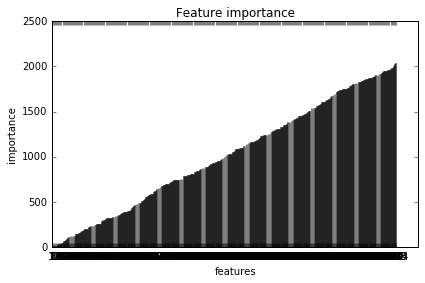

In [110]:
import numpy as np
import matplotlib.pyplot as plt

#plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(important_features))
bar_width = 0.35
plt.bar(index, important_features, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index + bar_width, important_features)
plt.tight_layout()

## Calculate Substructure Fingerprint Descriptors

In [9]:
! java -jar /Users/saw/Downloads/HDAC-Chembl/PaDEL-Descriptor/PaDEL-Descriptor.jar -fingerprints -descriptortypes /Users/saw/Downloads/HDAC-Chembl/PaDEL-Descriptor/descriptors_SubFP.xml  -dir /Users/saw/Downloads/HDAC-Chembl -file /Users/saw/Downloads/HDAC-Chembl/PaDEL-Descriptor/descriptors_output_file.csv

Processing AUTOGEN_HDAC_1 in HDAC.sdf (1/707). 
Processing AUTOGEN_HDAC_2 in HDAC.sdf (2/707). 
Processing AUTOGEN_HDAC_3 in HDAC.sdf (3/707). 
Processing AUTOGEN_HDAC_4 in HDAC.sdf (4/707). 
Processing AUTOGEN_HDAC_5 in HDAC.sdf (5/707). 
Processing AUTOGEN_HDAC_6 in HDAC.sdf (6/707). Average speed: 1.32 s/mol.
Processing AUTOGEN_HDAC_7 in HDAC.sdf (7/707). Average speed: 1.32 s/mol.
Processing AUTOGEN_HDAC_9 in HDAC.sdf (9/707). Average speed: 0.30 s/mol.
Processing AUTOGEN_HDAC_8 in HDAC.sdf (8/707). Average speed: 0.34 s/mol.
Processing AUTOGEN_HDAC_10 in HDAC.sdf (10/707). Average speed: 0.25 s/mol.
Processing AUTOGEN_HDAC_11 in HDAC.sdf (11/707). Average speed: 0.26 s/mol.
Processing AUTOGEN_HDAC_12 in HDAC.sdf (12/707). Average speed: 0.24 s/mol.
Processing AUTOGEN_HDAC_13 in HDAC.sdf (13/707). Average speed: 0.21 s/mol.
Processing AUTOGEN_HDAC_14 in HDAC.sdf (14/707). Average speed: 0.19 s/mol.
Processing AUTOGEN_HDAC_15 in HDAC.sdf (15/707). Average speed: 0.16 s/mol.
Processi

In [17]:
subFPC = pd.read_csv("PaDEL-Descriptor/descriptors_output_file.csv")
subFPC.drop("Name", inplace = True, axis = 1)
subFPC.head()

,SubFPC1,SubFPC2,SubFPC3,SubFPC4,SubFPC5,SubFPC6,SubFPC7,SubFPC8,SubFPC9,SubFPC10,SubFPC11,SubFPC12,SubFPC13,SubFPC14,SubFPC15,SubFPC16,SubFPC17,SubFPC18,SubFPC19,SubFPC20,SubFPC21,SubFPC22,SubFPC23,SubFPC24,SubFPC25,SubFPC26,SubFPC27,SubFPC28,SubFPC29,SubFPC30,SubFPC31,SubFPC32,SubFPC33,SubFPC34,SubFPC35,SubFPC36,SubFPC37,SubFPC38,SubFPC39,SubFPC40,SubFPC41,SubFPC42,SubFPC43,SubFPC44,SubFPC45,SubFPC46,SubFPC47,SubFPC48,SubFPC49,SubFPC50,SubFPC51,SubFPC52,SubFPC53,SubFPC54,SubFPC55,SubFPC56,SubFPC57,SubFPC58,SubFPC59,SubFPC60,SubFPC61,SubFPC62,SubFPC63,SubFPC64,SubFPC65,SubFPC66,SubFPC67,SubFPC68,SubFPC69,SubFPC70,SubFPC71,SubFPC72,SubFPC73,SubFPC74,SubFPC75,SubFPC76,SubFPC77,SubFPC78,SubFPC79,SubFPC80,SubFPC81,SubFPC82,SubFPC83,SubFPC84,SubFPC85,SubFPC86,SubFPC87,SubFPC88,SubFPC89,SubFPC90,SubFPC91,SubFPC92,SubFPC93,SubFPC94,SubFPC95,SubFPC96,SubFPC97,SubFPC98,SubFPC99,SubFPC100,SubFPC101,SubFPC102,SubFPC103,SubFPC104,SubFPC105,SubFPC106,SubFPC107,SubFPC108,SubFPC109,SubFPC110,SubFPC111,SubFPC112,SubFPC113,SubFPC114,SubFPC115,SubFPC116,SubFPC117,SubFPC118,SubFPC119,SubFPC120,SubFPC121,SubFPC122,SubFPC123,SubFPC124,SubFPC125,SubFPC126,SubFPC127,SubFPC128,SubFPC129,SubFPC130,SubFPC131,SubFPC132,SubFPC133,SubFPC134,SubFPC135,SubFPC136,SubFPC137,SubFPC138,SubFPC139,SubFPC140,SubFPC141,SubFPC142,SubFPC143,SubFPC144,SubFPC145,SubFPC146,SubFPC147,SubFPC148,SubFPC149,SubFPC150,SubFPC151,SubFPC152,SubFPC153,SubFPC154,SubFPC155,SubFPC156,SubFPC157,SubFPC158,SubFPC159,SubFPC160,SubFPC161,SubFPC162,SubFPC163,SubFPC164,SubFPC165,SubFPC166,SubFPC167,SubFPC168,SubFPC169,SubFPC170,SubFPC171,SubFPC172,SubFPC173,SubFPC174,SubFPC175,SubFPC176,SubFPC177,SubFPC178,SubFPC179,SubFPC180,SubFPC181,SubFPC182,SubFPC183,SubFPC184,SubFPC185,SubFPC186,SubFPC187,SubFPC188,SubFPC189,SubFPC190,SubFPC191,SubFPC192,SubFPC193,SubFPC194,SubFPC195,SubFPC196,SubFPC197,SubFPC198,SubFPC199,SubFPC200,SubFPC201,SubFPC202,SubFPC203,SubFPC204,SubFPC205,SubFPC206,SubFPC207,SubFPC208,SubFPC209,SubFPC210,SubFPC211,SubFPC212,SubFPC213,SubFPC214,SubFPC215,SubFPC216,SubFPC217,SubFPC218,SubFPC219,SubFPC220,SubFPC221,SubFPC222,SubFPC223,SubFPC224,SubFPC225,SubFPC226,SubFPC227,SubFPC228,SubFPC229,SubFPC230,SubFPC231,SubFPC232,SubFPC233,SubFPC234,SubFPC235,SubFPC236,SubFPC237,SubFPC238,SubFPC239,SubFPC240,SubFPC241,SubFPC242,SubFPC243,SubFPC244,SubFPC245,SubFPC246,SubFPC247,SubFPC248,SubFPC249,SubFPC250,SubFPC251,SubFPC252,SubFPC253,SubFPC254,SubFPC255,SubFPC256,SubFPC257,SubFPC258,SubFPC259,SubFPC260,SubFPC261,SubFPC262,SubFPC263,SubFPC264,SubFPC265,SubFPC266,SubFPC267,SubFPC268,SubFPC269,SubFPC270,SubFPC271,SubFPC272,SubFPC273,SubFPC274,SubFPC275,SubFPC276,SubFPC277,SubFPC278,SubFPC279,SubFPC280,SubFPC281,SubFPC282,SubFPC283,SubFPC284,SubFPC285,SubFPC286,SubFPC287,SubFPC288,SubFPC289,SubFPC290,SubFPC291,SubFPC292,SubFPC293,SubFPC294,SubFPC295,SubFPC296,SubFPC297,SubFPC298,SubFPC299,SubFPC300,SubFPC301,SubFPC302,SubFPC303,SubFPC304,SubFPC305,SubFPC306,SubFPC307
0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Training the Random Forest Model using Substructure Fingerprint Count

In [55]:
X_train, X_test, y_train, y_test = train_test_split(subFPC, pIC50,
        test_size = 0.2)
rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt')
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

## Feature Importance plot using SubStructure Fingerprint Count

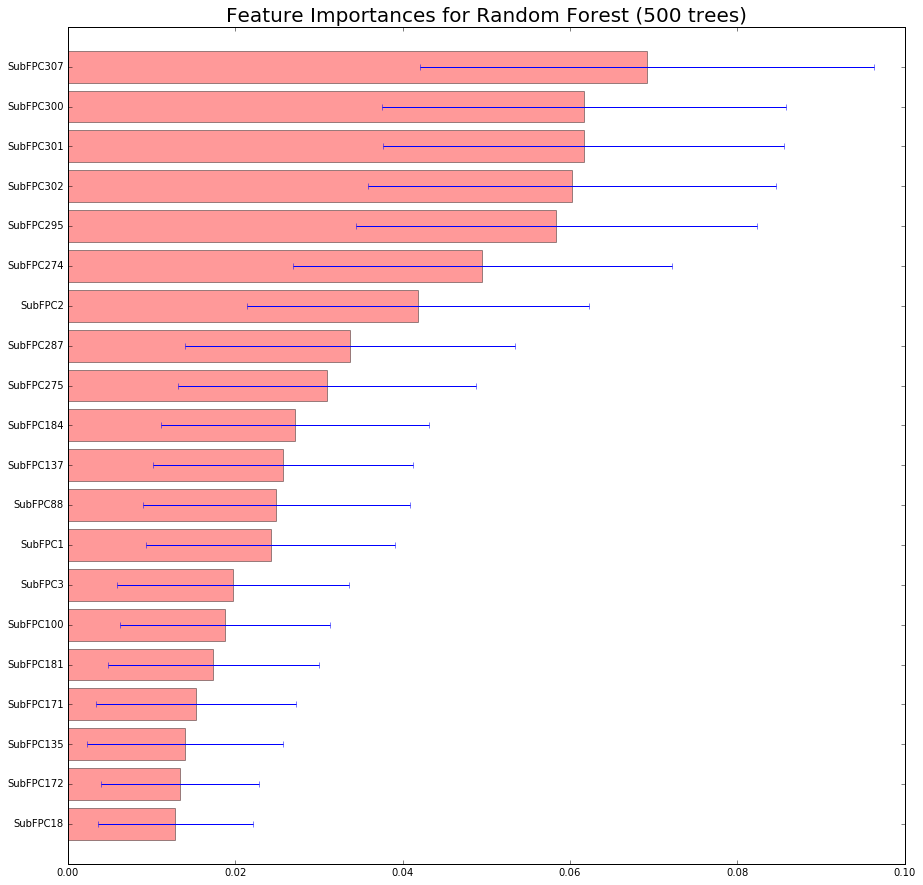

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

importance = np.mean([tree.feature_importances_ for tree in rf.estimators_],axis=0)
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
ind = np.argsort(importance)[-20:]
plt.figure(figsize=(15,15))
plt.title("Feature Importances for Random Forest (500 trees)", size = 20)
plt.barh(range(20),importance[ind],
       color="r", xerr=std[ind], alpha=0.4, align="center")
plt.yticks(range(20), subFPC.columns[ind])
plt.ylim([-1, len(ind)])
plt.show()